In [1]:
#!/usr/bin/env python3

from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.datasets import dump_svmlight_file
from sklearn import metrics
from sklearn.metrics import accuracy_score
import numpy as np
import logging
import codecs
import re
import os
from nltk.corpus import sentiwordnet as swn


def parse_dataset(fp):
    '''
    Loads the dataset .txt file with label-tweet on each line and parses the dataset.
    :param fp: filepath of dataset
    :return:
        corpus: list of tweet strings of each tweet.
        y: list of labels
    '''
    y = []
    corpus = []
    with open(fp, 'rt') as data_in:
        for line in data_in:
            if not line.lower().startswith("tweet index"):  # discard first line if it contains metadata
                line = line.rstrip()  # remove trailing whitespace
                label = int(line.split("\t")[1])
                tweet = line.split("\t")[2]
                y.append(label)
                corpus.append(tweet)

    return corpus, y


def featurize(corpus):
    '''
    Tokenizes and creates TF-IDF BoW vectors.
    :param corpus: A list of strings each string representing document.
    :return: X: A sparse csr matrix of TFIDF-weigted ngram counts.
    '''

    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True).tokenize
    vectorizer = TfidfVectorizer(strip_accents="unicode", analyzer="word", tokenizer=tokenizer, stop_words="english")
    X = vectorizer.fit_transform(corpus)
    # print(vectorizer.get_feature_names()) # to manually check if the tokens are reasonable
    return X


In [2]:
# Dataset: SemEval2018-T4-train-taskA.txt or SemEval2018-T4-train-taskB.txt
DATASET_FP1 = "./SemEval2018-Task3/datasets/train/SemEval2018-T4-train-taskA.txt"
TASK1 = "A"  # Define, A or B
DATASET_FP2 = "./SemEval2018-Task3/datasets/train/SemEval2018-T4-train-taskB.txt"
TASK2 = "B"  # Define, A or B

FNAME = './predictions-task' + TASK1 + '.txt'
PREDICTIONSFILE = open(FNAME, "w")

In [3]:
corpus, inp_y1 = parse_dataset(DATASET_FP1)
corpus_copy, inp_y2 = parse_dataset(DATASET_FP2)
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True).tokenize

In [4]:
import pandas as pd
raw_data = {'corpus' : [line for line in corpus], 'coarse_label': [line for line in inp_y1], 'fine_type': [line for line in inp_y2]}
df = pd.DataFrame(raw_data, columns=["corpus", "coarse_label", "fine_type"])

In [5]:
from sklearn.model_selection import train_test_split
# create train and validation set 
train, val = train_test_split(df, test_size=0.1)
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)

In [6]:
import torch
from torchtext.data import Field
from pymagnitude import Magnitude

class PyMagnitudeField(Field):

    def __init__(self, magnitude_vector_filepath, sequential=True, 
                 lower=True, tokenize=(lambda s: s.split()), 
                 include_lengths=True, batch_first=True, **kwargs):
        
        if kwargs.get('use_vocab'):
            kwargs['use_vocab'] = False
        self.vectors = Magnitude(magnitude_vector_filepath)
        super(PyMagnitudeField, self).__init__(sequential=sequential,
                                             lower=lower, 
                                             tokenize=tokenize, 
                                             include_lengths=include_lengths, 
                                             batch_first=batch_first, 
                                             **kwargs)
    
    def build_vocab(self, *args, **kwargs):
        pass
        
    def process(self, batch, device):
        if self.include_lengths:
            batch = (batch, [len(x) for x in batch])
        return self.numericalize(batch, device=torch.device('cpu'), train=True)
    
    def numericalize(self, arr, device=torch.device('cpu'), train=True):
        
        if self.include_lengths and not isinstance(arr, tuple):
            raise ValueError('Field has include_lengths set to True, but '
                             'input data is not a tuple of '
                             '(data batch, batch lengths).')
        
        if isinstance(arr, tuple):
            arr, lengths = arr
            lengths = torch.LongTensor(lengths)
        
        arr = torch.from_numpy(self.vectors.query(arr))
        if self.sequential and not self.batch_first:
            arr.t_()
           
        if device.type == 'cpu':
            if self.sequential:
                arr = arr.contiguous()
        else:
            arr = arr.cuda(device)
            if self.include_lengths:
                lengths = lengths.cuda(device)
        
        arr.requires_grad = False
        if self.include_lengths:
            return arr, lengths
        return arr

In [7]:
import torchtext
import spacy
import csv
from torchtext import data

# tokenizer function using spacy
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): 
    return [w.text.lower() for w in nlp(tweet_clean(s))]

def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text.strip()

# define the columns that we want to process and how to process
txt_field = data.Field(sequential=True, 
                       tokenize=tokenizer, 
                       include_lengths=True, 
                       use_vocab=True)
labelc_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)
labelf_field = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                         unk_token=None)

train_val_fields = [
    ('corpus', txt_field), # process it as text
    ('coarse_label', labelc_field), # process it as label
    ('fine_type', labelf_field) # we dont need this, so no processing
]

trainds, valds = data.TabularDataset.splits(path='./', 
                                            format='csv', 
                                            train='train.csv', 
                                            validation='val.csv', 
                                            fields=train_val_fields, 
                                            skip_header=True)

In [8]:
type(trainds)
len(trainds), len(valds)

(3450, 384)

In [9]:
trainds.fields.items()

[('corpus', <torchtext.data.field.Field at 0x10e8171d0>),
 ('coarse_label', <torchtext.data.field.Field at 0x113cfcb10>),
 ('fine_type', <torchtext.data.field.Field at 0x10e817a50>)]

In [10]:
ex = trainds[2]
type(ex)
ex.corpus

[u'something',
 u'to',
 u'remember',
 u'as',
 u'i',
 u'head',
 u'to',
 u'annexbar',
 u'tonight',
 u'goodboy',
 u'http',
 u't',
 u'co',
 u'bf5eviebwu']

In [11]:
from pymagnitude import *
vectors = Magnitude("glove.twitter.27B.25d.magnitude")

In [12]:
vectors.query('the')

array([-1.489600e-03,  2.958700e-03,  3.146130e-02,  2.533110e-02,
       -6.396720e-02, -2.151870e-02,  2.700136e-01, -2.308060e-02,
        2.664680e-02, -4.656560e-02,  1.002020e-02,  7.585990e-02,
       -9.284841e-01,  7.042420e-02,  2.018550e-02, -7.115970e-02,
        5.714110e-02, -2.858000e-04, -1.497100e-02,  3.115210e-02,
       -1.262173e-01,  2.529300e-02,  2.752000e-02, -1.234394e-01,
       -4.572460e-02], dtype=float32)

In [13]:
from torchtext import vocab
vec = vocab.Vectors('glove.twitter.27B.100d.txt', './vector_cache/glove.twitter.27B')
#os.path.isdir('./vector_cache/glove.twitter.27B')

In [14]:
txt_field.build_vocab(trainds, valds, vectors=vec)
#txt_field.build_vocab(trainds, valds)
# build vocab for labels
labelc_field.build_vocab(trainds)
labelf_field.build_vocab(trainds)

In [15]:
print(txt_field.vocab.stoi['a'])

6


In [16]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.corpus), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [17]:
len(traindl), len(valdl)

(1150, 128)

In [18]:
batch = next(iter(traindl))
type(batch)
batch.fine_type

tensor([1, 2, 1])

In [19]:
batch.corpus

(tensor([[ 131, 2323,  395],
         [  80,  127, 1689],
         [ 464,   39,    5],
         [   9, 1047,    2],
         [  42,    5, 7085],
         [   3,    2,   33],
         [ 110,  336, 7391],
         [ 208,  960,  389],
         [  55,   11, 1113],
         [1462,  146,  525],
         [  69,    1,    1]]), tensor([11, 10, 10]))

In [20]:
batch.dataset.fields

{'coarse_label': <torchtext.data.field.Field at 0x113cfcb10>,
 'corpus': <torchtext.data.field.Field at 0x10e8171d0>,
 'fine_type': <torchtext.data.field.Field at 0x10e817a50>}

In [21]:
txt_field.vocab.itos[0]

'<unk>'

In [22]:
txt_field.vocab.itos[1]

'<pad>'

In [23]:
def idxtosent(batch, idx):
    return ' '.join([txt_field.vocab.itos[i] for i in batch.corpus[0][:,idx].cpu().data.numpy()])

In [24]:
idxtosent(batch,2)

u'finally taken to the gir love heartbroken 12 19 14 <pad>'

In [25]:
batch.__dict__

{'batch_size': 3,
 'coarse_label': tensor([1, 1, 1]),
 'corpus': (tensor([[ 131, 2323,  395],
          [  80,  127, 1689],
          [ 464,   39,    5],
          [   9, 1047,    2],
          [  42,    5, 7085],
          [   3,    2,   33],
          [ 110,  336, 7391],
          [ 208,  960,  389],
          [  55,   11, 1113],
          [1462,  146,  525],
          [  69,    1,    1]]), tensor([11, 10, 10])),
 'dataset': <torchtext.data.dataset.TabularDataset at 0x10e85ba50>,
 'fields': ['corpus', 'coarse_label', 'fine_type'],
 'fine_type': tensor([1, 2, 1]),
 'input_fields': ['corpus', 'coarse_label', 'fine_type'],
 'target_fields': []}

In [26]:
val_batch = next(iter(valdl))
val_batch.__dict__

{'batch_size': 3,
 'coarse_label': tensor([1, 1, 1]),
 'corpus': (tensor([[11614,  5013,  4312],
          [ 9535,  2260,  1308],
          [  690,     1,     1],
          [10997,     1,     1]]), tensor([4, 2, 2])),
 'dataset': <torchtext.data.dataset.TabularDataset at 0x10e85bad0>,
 'fields': ['corpus', 'coarse_label', 'fine_type'],
 'fine_type': tensor([1, 1, 1]),
 'input_fields': ['corpus', 'coarse_label', 'fine_type'],
 'target_fields': []}

In [27]:
class BatchGenerator:
    def __init__(self, dl, x_field, yc_field, yf_field):
        self.dl, self.x_field, self.yc_field, self.yf_field = dl, x_field, yc_field, yf_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            yc = getattr(batch, self.yc_field)
            yf = getattr(batch, self.yf_field)
            yield (X,yc,yf)
            
train_batch_it = BatchGenerator(traindl, 'corpus', 'coarse_label', 'fine_type')
print(next(iter(train_batch_it)))

((tensor([[    3,     3,  4972],
        [   26,  1365,  5611],
        [ 8604,     6,    58],
        [   40,   458,   843],
        [   15,     5,   910],
        [  288,     6,    13],
        [  331,   462,   373],
        [  262,  9872,     8],
        [   25,     8,     4],
        [ 3728,     4,     7],
        [ 6052,     7, 10718],
        [   10, 10106,   402],
        [  134,  3265,  3536],
        [ 5072,   972,     8],
        [ 3276,  1149,     4],
        [   87,  1293,     7],
        [11241,  1973,   806]]), tensor([17, 17, 17])), tensor([1, 0, 0]), tensor([1, 0, 0]))


In [28]:
embedding_dim = 100
n_hidden = 64
n_out_yc = max(inp_y1)+1
n_out_yf = max(inp_y2)+1
vocab_size = len(txt_field.vocab)
device=torch.device('cpu')

In [29]:
vocab_size

12675

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.utils.data
import gc
import resource
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')
print(torch.__version__)

0.4.1


In [31]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out_yc, n_out_yf, pretrained_vec, bidirectional=True):
        super(SimpleGRU,self).__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out_yc,self.n_out_yf,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out_yc, n_out_yf, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.outc = nn.Linear(self.n_hidden, self.n_out_yc)
        self.outf = nn.Linear(self.n_hidden, self.n_out_yf)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outpc = self.outc(self.h[-1]) # self.h[-1] contains hidden state of last timestep
        outpf = self.outf(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outpc), F.log_softmax(outpf)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

In [32]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out_yc, n_out_yf, pretrained_vec, bidirectional=True):
        super(ConcatPoolingGRUAdaptive,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out_yc = n_out_yc
        self.n_out_yf = n_out_yf
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out_yc = nn.Linear(self.n_hidden*2*2, self.n_out_yc)
            self.out_yf = nn.Linear(self.n_hidden*2*2, self.n_out_yf)
        else:
            self.out_yc = nn.Linear(self.n_hidden*2, self.n_out_yc)
            self.out_yf = nn.Linear(self.n_hidden*2, self.n_out_yf)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)        
        outpyc = self.out_yc(torch.cat([avg_pool,max_pool],dim=1))
        outpyf = self.out_yf(torch.cat([avg_pool,max_pool],dim=1))
        return F.log_softmax(outpyc), F.log_softmax(outpyf)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

In [33]:
t = tqdm_notebook(iter(train_batch_it), leave=False, total=len(train_batch_it))

In [34]:
for (X,lengths),y1, y2 in t:
    print(lengths)

tensor([23, 22, 22])
tensor([13, 13, 13])
tensor([7, 7, 7])
tensor([14, 14, 14])
tensor([20, 19, 19])
tensor([11, 11, 11])
tensor([11, 10, 10])
tensor([14, 14, 14])
tensor([16, 16, 16])
tensor([8, 8, 8])
tensor([6, 6, 6])
tensor([22, 21, 21])
tensor([18, 18, 18])
tensor([17, 17, 17])
tensor([20, 20, 20])
tensor([19, 19, 19])
tensor([15, 15, 15])
tensor([24, 24, 24])
tensor([18, 18, 17])
tensor([14, 14, 14])
tensor([6, 6, 6])
tensor([9, 9, 9])
tensor([8, 8, 8])
tensor([14, 14, 14])
tensor([26, 26, 26])
tensor([9, 9, 9])
tensor([22, 22, 22])
tensor([9, 9, 8])
tensor([8, 8, 8])
tensor([7, 7, 7])
tensor([12, 12, 12])
tensor([11, 11, 11])
tensor([25, 25, 25])
tensor([8, 8, 8])
tensor([23, 23, 23])
tensor([24, 24, 23])
tensor([20, 20, 20])
tensor([18, 18, 18])
tensor([25, 25, 24])
tensor([18, 18, 18])
tensor([11, 11, 11])
tensor([5, 4, 4])
tensor([17, 17, 17])
tensor([23, 23, 23])
tensor([22, 22, 22])
tensor([22, 22, 22])
tensor([18, 18, 18])
tensor([6, 6, 6])
tensor([12, 12, 12])
tensor([2,

tensor([18, 18, 18])
tensor([9, 9, 9])
tensor([14, 14, 14])
tensor([13, 13, 13])
tensor([21, 21, 21])
tensor([19, 19, 19])
tensor([26, 26, 26])
tensor([24, 24, 24])
tensor([27, 27, 26])
tensor([7, 7, 7])
tensor([16, 16, 16])
tensor([21, 21, 21])
tensor([16, 16, 16])
tensor([9, 9, 9])
tensor([10, 10, 10])
tensor([9, 9, 9])
tensor([10, 10, 10])
tensor([7, 7, 7])
tensor([3, 3, 3])
tensor([15, 15, 15])
tensor([10, 10, 10])
tensor([20, 20, 20])
tensor([6, 6, 5])
tensor([7, 7, 7])
tensor([14, 13, 13])
tensor([5, 5, 5])
tensor([12, 12, 11])
tensor([10, 10, 10])
tensor([7, 7, 7])
tensor([17, 17, 17])
tensor([8, 8, 8])
tensor([6, 6, 6])
tensor([10, 10, 10])
tensor([12, 12, 12])
tensor([12, 12, 12])
tensor([21, 21, 21])
tensor([4, 4, 3])
tensor([12, 12, 12])
tensor([14, 14, 14])
tensor([10, 10, 10])
tensor([6, 6, 6])
tensor([16, 16, 16])
tensor([21, 21, 21])
tensor([9, 9, 9])
tensor([11, 11, 11])
tensor([20, 20, 20])
tensor([9, 9, 9])
tensor([11, 11, 11])
tensor([17, 17, 17])
tensor([20, 20, 20]

tensor([19, 19, 19])
tensor([13, 13, 13])
tensor([21, 21, 21])
tensor([6, 6, 6])
tensor([10, 10, 10])
tensor([26, 26, 26])
tensor([15, 15, 15])
tensor([7, 7, 7])
tensor([7, 7, 6])
tensor([9, 9, 9])
tensor([20, 20, 20])
tensor([13, 13, 13])
tensor([10, 10, 10])
tensor([14, 14, 14])
tensor([15, 15, 15])
tensor([6, 6, 6])
tensor([14, 14, 14])
tensor([13, 13, 13])
tensor([21, 21, 21])
tensor([27, 26, 26])
tensor([17, 17, 17])
tensor([20, 20, 20])
tensor([22, 22, 22])
tensor([20, 20, 20])
tensor([17, 17, 17])
tensor([10, 10, 10])
tensor([41, 37, 30])
tensor([6, 5, 5])
tensor([16, 16, 16])
tensor([9, 9, 9])
tensor([23, 23, 23])
tensor([18, 18, 18])
tensor([12, 12, 12])
tensor([15, 14, 14])
tensor([55, 54, 43])
tensor([11, 11, 10])
tensor([12, 12, 12])
tensor([8, 8, 8])
tensor([24, 24, 24])
tensor([23, 23, 23])
tensor([14, 13, 13])
tensor([14, 14, 14])
tensor([13, 13, 13])
tensor([20, 20, 20])
tensor([16, 16, 16])
tensor([26, 26, 26])
tensor([6, 6, 6])
tensor([10, 10, 10])
tensor([25, 24, 24]

In [35]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    train_loss_list = list()
    train_acc_list = list()
    val_loss_list = list()
    val_acc_list = list()
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        z_true_train = list()
        z_pred_train = list()
        total_lossy_train = 0
        total_lossz_train = 0
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y,z in t:
            t.set_description('Epoch %d' % epoch)
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            predy,predz = model(X, lengths)
            lossy = loss_fn(predy, y)
            
            lossz = loss_fn(predz, z)
            
            loss = lossy + lossz
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idxy = torch.max(predy, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idxy.cpu().data.numpy())
            total_lossy_train += lossy.item()
            
            pred_idxz = torch.max(predz, dim=1)[1]
            
            z_true_train += list(z.cpu().data.numpy())
            z_pred_train += list(pred_idxz.cpu().data.numpy())
            total_lossz_train += lossz.item()
            
            total_loss_train += loss.item()
            
        train_accy = accuracy_score(y_true_train, y_pred_train)
        train_lossy = total_lossy_train/len(train_dl)
        
        train_accz = accuracy_score(z_true_train, z_pred_train)
        train_lossz = total_lossz_train/len(train_dl)
        
        train_acc = (train_accy+train_accz)/2.0
        train_loss = total_loss_train/len(train_dl)
        
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_lossy_val = 0
            
            z_true_val = list()
            z_pred_val = list()
            total_lossz_val = 0
            
            total_loss_val = 0
            for (X,lengths),y,z in tqdm_notebook(val_dl, leave=False):
                predy, predz = model(X, lengths.cpu().numpy())
                
                lossy = loss_fn(predy, y)
                lossz = loss_fn(predz, z)
                loss = lossy+lossz
                
                pred_idxy = torch.max(predy, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idxy.cpu().data.numpy())
                total_lossy_val += lossy.item()
                
                pred_idxz = torch.max(predz, 1)[1]
                z_true_val += list(z.cpu().data.numpy())
                z_pred_val += list(pred_idxz.cpu().data.numpy())
                total_lossz_val += lossz.item()
                
                total_loss_val += loss.item()
            
            valaccy = accuracy_score(y_true_val, y_pred_val)
            vallossy = total_lossy_val/len(valdl)
            
            valaccz = accuracy_score(z_true_val, z_pred_val)
            vallossz = total_lossz_val/len(valdl)
            
            valacc = (valaccy+valaccz)/2.0
            valloss = total_loss_val/len(valdl)
            
            val_acc_list.append(valacc)
            val_loss_list.append(valloss)
            
            print ('Epoch [%d/%d] train_loss: %.4f, train_acc: %.4f, val_loss: %.4f, val_acc: %.4f ' 
                   %(epoch+1, epochs, train_loss, train_acc, valloss, valacc))
        else:
            print ('Epoch [%d/%d] train_loss: %.4f, train_acc: %.4f ' 
                   %(epoch+1, epochs, train_loss, train_acc))
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [36]:
train_batch_it = BatchGenerator(traindl, 'corpus', 'coarse_label', 'fine_type')
val_batch_it = BatchGenerator(valdl, 'corpus', 'coarse_label', 'fine_type')

In [37]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out_yc, n_out_yf, trainds.fields['corpus'].vocab.vectors).to(device)
for i in m.parameters():
    print(i.shape)

torch.Size([12675, 100])
torch.Size([192, 100])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([192, 100])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([2, 64])
torch.Size([2])
torch.Size([4, 64])
torch.Size([4])


In [38]:
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

train_acc_list, train_loss_list, val_acc_list, val_loss_list = fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=50)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50] train_loss: 1.6763, train_acc: 0.5788, val_loss: 1.5835, val_acc: 0.6172 


Epoch [2/50] train_loss: 1.5114, train_acc: 0.6458, val_loss: 1.5956, val_acc: 0.6393 


Epoch [3/50] train_loss: 1.4063, train_acc: 0.6764, val_loss: 1.5178, val_acc: 0.6458 


Epoch [4/50] train_loss: 1.2904, train_acc: 0.7162, val_loss: 1.5504, val_acc: 0.6562 


Epoch [5/50] train_loss: 1.1385, train_acc: 0.7580, val_loss: 1.6418, val_acc: 0.6211 


Epoch [6/50] train_loss: 0.9495, train_acc: 0.8065, val_loss: 1.8357, val_acc: 0.6263 


Epoch [7/50] train_loss: 0.7370, train_acc: 0.8590, val_loss: 2.0082, val_acc: 0.5964 


Epoch [8/50] train_loss: 0.5248, train_acc: 0.9036, val_loss: 2.5005, val_acc: 0.5872 


Epoch [9/50] train_loss: 0.3483, train_acc: 0.9429, val_loss: 2.7738, val_acc: 0.5924 


Epoch [10/50] train_loss: 0.2458, train_acc: 0.9625, val_loss: 3.2339, val_acc: 0.5794 


Epoch [11/50] train_loss: 0.1669, train_acc: 0.9788, val_loss: 4.0740, val_acc: 0.5924 


Epoch [12/50] train_loss: 0.1206, train_acc: 0.9848, val_loss: 4.4786, val_acc: 0.5833 


Epoch [13/50] train_loss: 0.1043, train_acc: 0.9848, val_loss: 4.2605, val_acc: 0.5872 


Epoch [14/50] train_loss: 0.0846, train_acc: 0.9894, val_loss: 4.2447, val_acc: 0.6003 


Epoch [15/50] train_loss: 0.0478, train_acc: 0.9946, val_loss: 4.7568, val_acc: 0.5990 


Epoch [16/50] train_loss: 0.1239, train_acc: 0.9816, val_loss: 4.7264, val_acc: 0.5807 


Epoch [17/50] train_loss: 0.0600, train_acc: 0.9922, val_loss: 4.7539, val_acc: 0.5938 


Epoch [18/50] train_loss: 0.0460, train_acc: 0.9946, val_loss: 4.9862, val_acc: 0.5716 


Epoch [19/50] train_loss: 0.0406, train_acc: 0.9957, val_loss: 4.7117, val_acc: 0.5911 


Epoch [20/50] train_loss: 0.0285, train_acc: 0.9975, val_loss: 5.1285, val_acc: 0.5885 


Epoch [21/50] train_loss: 0.0190, train_acc: 0.9988, val_loss: 5.1702, val_acc: 0.5938 


Epoch [22/50] train_loss: 0.1182, train_acc: 0.9791, val_loss: 4.9019, val_acc: 0.5977 


Epoch [23/50] train_loss: 0.0440, train_acc: 0.9939, val_loss: 5.2029, val_acc: 0.5807 


Epoch [24/50] train_loss: 0.0110, train_acc: 0.9991, val_loss: 5.5647, val_acc: 0.5833 


Epoch [25/50] train_loss: 0.0044, train_acc: 0.9999, val_loss: 5.8156, val_acc: 0.5794 


Epoch [26/50] train_loss: 0.0025, train_acc: 0.9999, val_loss: 6.1100, val_acc: 0.5833 


Epoch [27/50] train_loss: 0.0016, train_acc: 1.0000, val_loss: 6.3728, val_acc: 0.5820 


Epoch [28/50] train_loss: 0.0009, train_acc: 1.0000, val_loss: 6.7639, val_acc: 0.5859 


Epoch [29/50] train_loss: 0.0005, train_acc: 1.0000, val_loss: 7.1123, val_acc: 0.5807 


Epoch [30/50] train_loss: 0.0003, train_acc: 1.0000, val_loss: 7.5072, val_acc: 0.5742 


Epoch [31/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 7.9493, val_acc: 0.5690 


Epoch [32/50] train_loss: 0.2265, train_acc: 0.9680, val_loss: 6.0968, val_acc: 0.5885 


Epoch [33/50] train_loss: 0.0721, train_acc: 0.9868, val_loss: 5.7560, val_acc: 0.5716 


Epoch [34/50] train_loss: 0.0117, train_acc: 0.9988, val_loss: 6.0146, val_acc: 0.5651 


Epoch [35/50] train_loss: 0.0029, train_acc: 1.0000, val_loss: 6.1968, val_acc: 0.5599 


Epoch [36/50] train_loss: 0.0015, train_acc: 1.0000, val_loss: 6.3793, val_acc: 0.5664 


Epoch [37/50] train_loss: 0.0009, train_acc: 1.0000, val_loss: 6.5735, val_acc: 0.5638 


Epoch [38/50] train_loss: 0.0006, train_acc: 1.0000, val_loss: 6.8209, val_acc: 0.5586 


Epoch [39/50] train_loss: 0.0004, train_acc: 1.0000, val_loss: 7.0816, val_acc: 0.5547 


Epoch [40/50] train_loss: 0.0002, train_acc: 1.0000, val_loss: 7.3976, val_acc: 0.5651 


Epoch [41/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 7.7657, val_acc: 0.5638 


Epoch [42/50] train_loss: 0.0001, train_acc: 1.0000, val_loss: 8.0809, val_acc: 0.5638 


Epoch [43/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 8.4436, val_acc: 0.5638 


Epoch [44/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 8.8781, val_acc: 0.5651 


Epoch [45/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 9.2601, val_acc: 0.5638 


Epoch [46/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 9.6819, val_acc: 0.5677 


Epoch [47/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 10.0125, val_acc: 0.5599 


Epoch [48/50] train_loss: 0.0000, train_acc: 1.0000, val_loss: 10.4498, val_acc: 0.5664 


Epoch [49/50] train_loss: 0.3228, train_acc: 0.9629, val_loss: 7.5208, val_acc: 0.5977 


Epoch [50/50] train_loss: 0.0573, train_acc: 0.9897, val_loss: 7.0544, val_acc: 0.5794 



In [39]:
import matplotlib.pyplot as plt

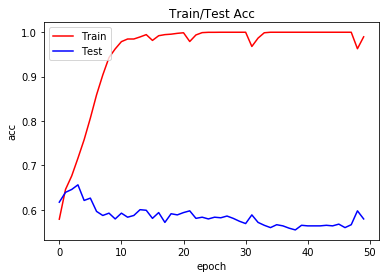

In [40]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc_list, color='red')
line2 = plt.plot(val_acc_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpgruacc.png')   # save the figure to file
plt.show()
plt.close()

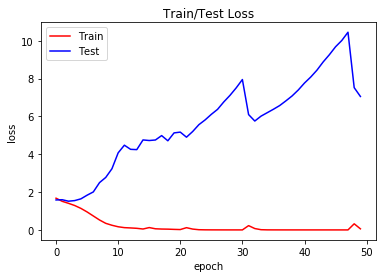

In [41]:
#plot train/val accuracies
plt.title("Train/Test Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
line1 = plt.plot(train_loss_list, color='red')
line2 = plt.plot(val_loss_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpgruloss.png')   # save the figure to file
plt.show()
plt.close()

In [42]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out_yc, n_out_yf, trainds.fields['corpus'].vocab.vectors).to(device)
for i in m.parameters():
    print(i.shape)

torch.Size([12675, 100])
torch.Size([192, 100])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([192, 100])
torch.Size([192, 64])
torch.Size([192])
torch.Size([192])
torch.Size([2, 256])
torch.Size([2])
torch.Size([4, 256])
torch.Size([4])


In [43]:
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

train_acc_list, train_loss_list, val_acc_list, val_loss_list = fit(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=50)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50] train_loss: 1.6291, train_acc: 0.6030, val_loss: 1.5477, val_acc: 0.6159 


Epoch [2/50] train_loss: 1.4485, train_acc: 0.6693, val_loss: 1.5366, val_acc: 0.6458 


Epoch [3/50] train_loss: 1.3003, train_acc: 0.7183, val_loss: 1.6037, val_acc: 0.6289 


Epoch [4/50] train_loss: 1.1009, train_acc: 0.7691, val_loss: 1.5630, val_acc: 0.6328 


Epoch [5/50] train_loss: 0.8772, train_acc: 0.8346, val_loss: 1.7750, val_acc: 0.6237 


Epoch [6/50] train_loss: 0.6626, train_acc: 0.8857, val_loss: 1.7341, val_acc: 0.6289 


Epoch [7/50] train_loss: 0.4540, train_acc: 0.9358, val_loss: 1.9752, val_acc: 0.6081 


Epoch [8/50] train_loss: 0.3079, train_acc: 0.9626, val_loss: 2.0919, val_acc: 0.6354 


Epoch [9/50] train_loss: 0.1952, train_acc: 0.9796, val_loss: 2.2878, val_acc: 0.6146 


Epoch [10/50] train_loss: 0.1200, train_acc: 0.9912, val_loss: 2.7658, val_acc: 0.6159 


Epoch [11/50] train_loss: 0.0772, train_acc: 0.9954, val_loss: 2.9254, val_acc: 0.5977 


Epoch [12/50] train_loss: 0.0702, train_acc: 0.9928, val_loss: 3.1522, val_acc: 0.6003 


Epoch [13/50] train_loss: 0.0641, train_acc: 0.9955, val_loss: 3.2998, val_acc: 0.6042 


Epoch [14/50] train_loss: 0.0210, train_acc: 0.9991, val_loss: 3.4728, val_acc: 0.6055 


Epoch [15/50] train_loss: 0.0116, train_acc: 0.9997, val_loss: 3.5785, val_acc: 0.5964 


Epoch [16/50] train_loss: 0.0838, train_acc: 0.9868, val_loss: 3.7470, val_acc: 0.5716 


Epoch [17/50] train_loss: 0.0521, train_acc: 0.9942, val_loss: 3.6241, val_acc: 0.6029 


Epoch [18/50] train_loss: 0.0113, train_acc: 1.0000, val_loss: 3.7261, val_acc: 0.5924 


Epoch [19/50] train_loss: 0.0050, train_acc: 1.0000, val_loss: 3.8689, val_acc: 0.5964 


Epoch [20/50] train_loss: 0.0032, train_acc: 1.0000, val_loss: 4.0415, val_acc: 0.5859 


Epoch [21/50] train_loss: 0.0069, train_acc: 0.9990, val_loss: 4.6746, val_acc: 0.5977 


Epoch [22/50] train_loss: 0.1436, train_acc: 0.9742, val_loss: 3.8881, val_acc: 0.5807 


Epoch [23/50] train_loss: 0.0204, train_acc: 0.9988, val_loss: 3.8565, val_acc: 0.5859 


Epoch [24/50] train_loss: 0.0057, train_acc: 1.0000, val_loss: 3.9395, val_acc: 0.5768 


Epoch [25/50] train_loss: 0.0034, train_acc: 1.0000, val_loss: 4.0980, val_acc: 0.5755 


Epoch [26/50] train_loss: 0.0393, train_acc: 0.9926, val_loss: 4.6667, val_acc: 0.5703 


Epoch [27/50] train_loss: 0.0821, train_acc: 0.9852, val_loss: 4.2548, val_acc: 0.5885 


Epoch [28/50] train_loss: 0.0106, train_acc: 0.9991, val_loss: 4.2378, val_acc: 0.5977 


Epoch [29/50] train_loss: 0.0034, train_acc: 1.0000, val_loss: 4.3428, val_acc: 0.5951 


Epoch [30/50] train_loss: 0.0022, train_acc: 1.0000, val_loss: 4.4694, val_acc: 0.5898 


Epoch [31/50] train_loss: 0.0022, train_acc: 0.9999, val_loss: 4.6414, val_acc: 0.5859 


Epoch [32/50] train_loss: 0.0023, train_acc: 1.0000, val_loss: 4.7550, val_acc: 0.6042 


Epoch [33/50] train_loss: 0.0983, train_acc: 0.9858, val_loss: 4.3985, val_acc: 0.6146 


Epoch [34/50] train_loss: 0.0137, train_acc: 0.9983, val_loss: 4.5117, val_acc: 0.6146 


Epoch [35/50] train_loss: 0.0034, train_acc: 1.0000, val_loss: 4.5796, val_acc: 0.6029 


Epoch [36/50] train_loss: 0.0017, train_acc: 1.0000, val_loss: 4.7213, val_acc: 0.6042 


Epoch [37/50] train_loss: 0.0009, train_acc: 1.0000, val_loss: 4.8590, val_acc: 0.5977 


Epoch [38/50] train_loss: 0.0007, train_acc: 1.0000, val_loss: 5.0170, val_acc: 0.5898 


Epoch [39/50] train_loss: 0.0004, train_acc: 1.0000, val_loss: 5.1866, val_acc: 0.5872 


Epoch [40/50] train_loss: 0.0003, train_acc: 1.0000, val_loss: 5.3106, val_acc: 0.5872 


Epoch [41/50] train_loss: 0.0744, train_acc: 0.9878, val_loss: 5.3903, val_acc: 0.5924 


Epoch [42/50] train_loss: 0.0462, train_acc: 0.9936, val_loss: 5.3383, val_acc: 0.5885 


Epoch [43/50] train_loss: 0.0090, train_acc: 0.9991, val_loss: 5.4172, val_acc: 0.5859 


Epoch [44/50] train_loss: 0.0020, train_acc: 1.0000, val_loss: 5.4203, val_acc: 0.6016 


Epoch [45/50] train_loss: 0.0012, train_acc: 1.0000, val_loss: 5.4226, val_acc: 0.5938 


Epoch [46/50] train_loss: 0.0007, train_acc: 1.0000, val_loss: 5.4942, val_acc: 0.5911 


Epoch [47/50] train_loss: 0.0004, train_acc: 1.0000, val_loss: 5.6667, val_acc: 0.5924 


Epoch [48/50] train_loss: 0.0433, train_acc: 0.9932, val_loss: 5.8096, val_acc: 0.5794 


Epoch [49/50] train_loss: 0.0666, train_acc: 0.9887, val_loss: 5.2410, val_acc: 0.5885 


Epoch [50/50] train_loss: 0.0174, train_acc: 0.9978, val_loss: 5.8194, val_acc: 0.5898 



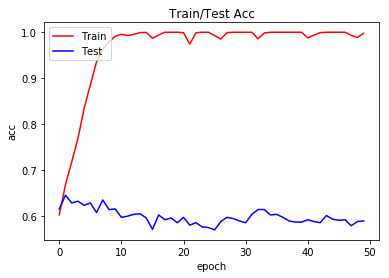

In [44]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc_list, color='red')
line2 = plt.plot(val_acc_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpcpgruacc.png')   # save the figure to file
plt.show()
plt.close()

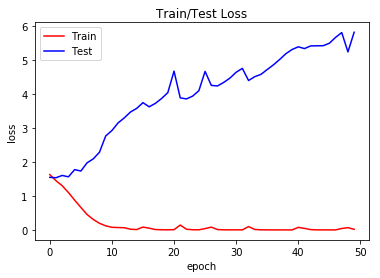

In [45]:
#plot train/val accuracies
plt.title("Train/Test Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
line1 = plt.plot(train_loss_list, color='red')
line2 = plt.plot(val_loss_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpcpgruloss.png')   # save the figure to file
plt.show()
plt.close()

In [46]:
import math
import torch
from torch.optim import Optimizer


class Adam(Optimizer):
    """Implements Adam algorithm.

    It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
    
    def step(self, alpha, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = alpha * group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

In [47]:
def fit_l1(model, train_dl, val_dl, loss_fn, opt_y, opt_z, epochs=3):
    num_batch = len(train_dl)
    train_loss_list = list()
    train_acc_list = list()
    val_loss_list = list()
    val_acc_list = list()
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        z_true_train = list()
        z_pred_train = list()
        total_lossy_train = 0
        total_lossz_train = 0
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y,z in t:
            t.set_description('Epoch %d' % epoch)
            lengths = lengths.cpu().numpy()
            
            opt_y.zero_grad()
            opt_z.zero_grad()
            
            predy,predz = model(X, lengths)
            
            lossy = loss_fn(predy, y)
            lossz = loss_fn(predz, z)
            loss = lossy + lossz
            
            alpha_ = lossz/(lossy+lossz)
            loss.backward()
            
            opt_y.step(alpha=alpha_.data)
            opt_z.step(alpha=(1-alpha_.data))
            
            t.set_postfix(loss=loss.item())
            pred_idxy = torch.max(predy, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idxy.cpu().data.numpy())
            total_lossy_train += lossy.item()
            
            pred_idxz = torch.max(predz, dim=1)[1]
            
            z_true_train += list(z.cpu().data.numpy())
            z_pred_train += list(pred_idxz.cpu().data.numpy())
            total_lossz_train += lossz.item()
            
            total_loss_train += loss.item()
            
        train_accy = accuracy_score(y_true_train, y_pred_train)
        train_lossy = total_lossy_train/len(train_dl)
        
        train_accz = accuracy_score(z_true_train, z_pred_train)
        train_lossz = total_lossz_train/len(train_dl)
        
        train_acc = (train_accy+train_accz)/2.0
        train_loss = total_loss_train/len(train_dl)
        
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_lossy_val = 0
            
            z_true_val = list()
            z_pred_val = list()
            total_lossz_val = 0
            
            total_loss_val = 0
            for (X,lengths),y,z in tqdm_notebook(val_dl, leave=False):
                predy, predz = model(X, lengths.cpu().numpy())
                
                lossy = loss_fn(predy, y)
                lossz = loss_fn(predz, z)
                loss = lossy+lossz
                
                pred_idxy = torch.max(predy, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idxy.cpu().data.numpy())
                total_lossy_val += lossy.item()
                
                pred_idxz = torch.max(predz, 1)[1]
                z_true_val += list(z.cpu().data.numpy())
                z_pred_val += list(pred_idxz.cpu().data.numpy())
                total_lossz_val += lossz.item()
                
                total_loss_val += loss.item()
            
            valaccy = accuracy_score(y_true_val, y_pred_val)
            vallossy = total_lossy_val/len(valdl)
            
            valaccz = accuracy_score(z_true_val, z_pred_val)
            vallossz = total_lossz_val/len(valdl)
            
            valacc = (valaccy+valaccz)/2.0
            valloss = total_loss_val/len(valdl)
            
            val_acc_list.append(valacc)
            val_loss_list.append(valloss)
            
            print ('Epoch [%d/%d] train_loss: %.4f, train_acc: %.4f, val_loss: %.4f, val_acc: %.4f ' 
                   %(epoch+1, epochs, train_loss, train_acc, valloss, valacc))
        else:
            print ('Epoch [%d/%d] train_loss: %.4f, train_acc: %.4f ' 
                   %(epoch+1, epochs, train_loss, train_acc))
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list

In [48]:
m = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out_yc, n_out_yf, trainds.fields['corpus'].vocab.vectors).to(device)
opt_y = Adam(filter(lambda p: p.requires_grad, [i for i in m.parameters() if i.shape != torch.Size([4]) and i.shape != torch.Size([4, 64])]), 1e-3)
opt_z = Adam(filter(lambda p: p.requires_grad, [i for i in m.parameters() if i.shape != torch.Size([2]) and i.shape != torch.Size([2, 64])]), 1e-3)

train_acc_list, train_loss_list, val_acc_list, val_loss_list = fit_l1(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt_y=opt_y, opt_z=opt_z, epochs=50)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50] train_loss: 1.6739, train_acc: 0.5787, val_loss: 1.5905, val_acc: 0.6224 


Epoch [2/50] train_loss: 1.5121, train_acc: 0.6488, val_loss: 1.5187, val_acc: 0.6628 


Epoch [3/50] train_loss: 1.4073, train_acc: 0.6787, val_loss: 1.5081, val_acc: 0.6445 


Epoch [4/50] train_loss: 1.2933, train_acc: 0.7172, val_loss: 1.5460, val_acc: 0.6510 


Epoch [5/50] train_loss: 1.1636, train_acc: 0.7568, val_loss: 1.5337, val_acc: 0.6641 


Epoch [6/50] train_loss: 1.0035, train_acc: 0.7967, val_loss: 1.7303, val_acc: 0.6549 


Epoch [7/50] train_loss: 0.8271, train_acc: 0.8387, val_loss: 1.7969, val_acc: 0.6445 


Epoch [8/50] train_loss: 0.6385, train_acc: 0.8830, val_loss: 1.9663, val_acc: 0.6523 


Epoch [9/50] train_loss: 0.4837, train_acc: 0.9136, val_loss: 2.4258, val_acc: 0.6120 


Epoch [10/50] train_loss: 0.3474, train_acc: 0.9435, val_loss: 2.4502, val_acc: 0.6133 


Epoch [11/50] train_loss: 0.2645, train_acc: 0.9583, val_loss: 3.1877, val_acc: 0.6042 


Epoch [12/50] train_loss: 0.2159, train_acc: 0.9671, val_loss: 2.9894, val_acc: 0.6185 


Epoch [13/50] train_loss: 0.1663, train_acc: 0.9783, val_loss: 3.1037, val_acc: 0.5924 


Epoch [14/50] train_loss: 0.1965, train_acc: 0.9728, val_loss: 3.4430, val_acc: 0.6016 


Epoch [15/50] train_loss: 0.1073, train_acc: 0.9868, val_loss: 3.6341, val_acc: 0.6068 


Epoch [16/50] train_loss: 0.1112, train_acc: 0.9865, val_loss: 3.9060, val_acc: 0.5951 


Epoch [17/50] train_loss: 0.1010, train_acc: 0.9872, val_loss: 4.3802, val_acc: 0.5938 


Epoch [18/50] train_loss: 0.0725, train_acc: 0.9932, val_loss: 4.4542, val_acc: 0.5742 


Epoch [19/50] train_loss: 0.0944, train_acc: 0.9888, val_loss: 4.5404, val_acc: 0.5768 


Epoch [20/50] train_loss: 0.1072, train_acc: 0.9868, val_loss: 4.1175, val_acc: 0.6133 


Epoch [21/50] train_loss: 0.0621, train_acc: 0.9946, val_loss: 4.3776, val_acc: 0.6016 


Epoch [22/50] train_loss: 0.0240, train_acc: 0.9987, val_loss: 4.9000, val_acc: 0.5938 


Epoch [23/50] train_loss: 0.0159, train_acc: 0.9994, val_loss: 5.0616, val_acc: 0.6016 


Epoch [24/50] train_loss: 0.0124, train_acc: 0.9996, val_loss: 5.4531, val_acc: 0.5938 


Epoch [25/50] train_loss: 0.1620, train_acc: 0.9745, val_loss: 4.2908, val_acc: 0.6068 


Epoch [26/50] train_loss: 0.0617, train_acc: 0.9913, val_loss: 4.4554, val_acc: 0.6315 


Epoch [27/50] train_loss: 0.0289, train_acc: 0.9978, val_loss: 4.7226, val_acc: 0.5951 


Epoch [28/50] train_loss: 0.0180, train_acc: 0.9994, val_loss: 4.9084, val_acc: 0.6081 


Epoch [29/50] train_loss: 0.0200, train_acc: 0.9972, val_loss: 4.7992, val_acc: 0.6393 


Epoch [30/50] train_loss: 0.1299, train_acc: 0.9784, val_loss: 4.6873, val_acc: 0.6185 


Epoch [31/50] train_loss: 0.0431, train_acc: 0.9945, val_loss: 4.6218, val_acc: 0.5977 


Epoch [32/50] train_loss: 0.0280, train_acc: 0.9965, val_loss: 4.9301, val_acc: 0.6055 


Epoch [33/50] train_loss: 0.0623, train_acc: 0.9910, val_loss: 4.5336, val_acc: 0.6250 


Epoch [34/50] train_loss: 0.0210, train_acc: 0.9987, val_loss: 4.6596, val_acc: 0.6081 


Epoch [35/50] train_loss: 0.0245, train_acc: 0.9978, val_loss: 4.7089, val_acc: 0.6003 


Epoch [36/50] train_loss: 0.0398, train_acc: 0.9942, val_loss: 4.9494, val_acc: 0.6042 


Epoch [37/50] train_loss: 0.0320, train_acc: 0.9964, val_loss: 5.3889, val_acc: 0.6081 


Epoch [38/50] train_loss: 0.0224, train_acc: 0.9972, val_loss: 5.3544, val_acc: 0.5794 


Epoch [39/50] train_loss: 0.0666, train_acc: 0.9910, val_loss: 4.9750, val_acc: 0.6055 


Epoch [40/50] train_loss: 0.0472, train_acc: 0.9951, val_loss: 4.8061, val_acc: 0.6094 


Epoch [41/50] train_loss: 0.0286, train_acc: 0.9971, val_loss: 5.3742, val_acc: 0.6029 


Epoch [42/50] train_loss: 0.0236, train_acc: 0.9981, val_loss: 5.4333, val_acc: 0.5964 


Epoch [43/50] train_loss: 0.0348, train_acc: 0.9954, val_loss: 5.2879, val_acc: 0.5990 


Epoch [44/50] train_loss: 0.0185, train_acc: 0.9987, val_loss: 5.4247, val_acc: 0.5872 


Epoch [45/50] train_loss: 0.0066, train_acc: 0.9999, val_loss: 5.3765, val_acc: 0.6198 


Epoch [46/50] train_loss: 0.0032, train_acc: 1.0000, val_loss: 5.6488, val_acc: 0.6159 


Epoch [47/50] train_loss: 0.0022, train_acc: 1.0000, val_loss: 5.8202, val_acc: 0.6159 


Epoch [48/50] train_loss: nan, train_acc: 0.7699, val_loss: nan, val_acc: 0.5052 


Epoch [49/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [50/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 



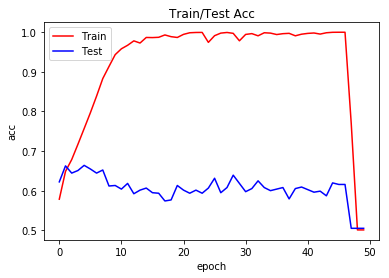

In [49]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc_list, color='red')
line2 = plt.plot(val_acc_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpgru11acc.png')   # save the figure to file
plt.show()
plt.close()

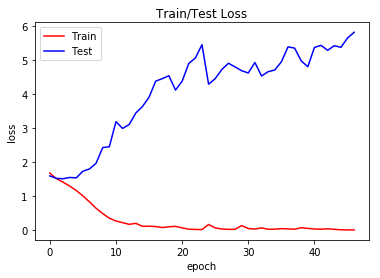

In [50]:
#plot train/val accuracies
plt.title("Train/Test Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
line1 = plt.plot(train_loss_list, color='red')
line2 = plt.plot(val_loss_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpgru11loss.png')   # save the figure to file
plt.show()
plt.close()

In [51]:
m = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out_yc, n_out_yf, trainds.fields['corpus'].vocab.vectors).to(device)
opt_y = Adam(filter(lambda p: p.requires_grad, [i for i in m.parameters() if i.shape != torch.Size([4]) and i.shape != torch.Size([4, 256])]), 1e-3)
opt_z = Adam(filter(lambda p: p.requires_grad, [i for i in m.parameters() if i.shape != torch.Size([2]) and i.shape != torch.Size([2, 256])]), 1e-3)

train_acc_list, train_loss_list, val_acc_list, val_loss_list = fit_l1(model=m, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt_y=opt_y, opt_z=opt_z, epochs=50)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50] train_loss: 1.6508, train_acc: 0.5809, val_loss: 1.5805, val_acc: 0.6081 


Epoch [2/50] train_loss: 1.4827, train_acc: 0.6630, val_loss: 1.5099, val_acc: 0.6536 


Epoch [3/50] train_loss: 1.3558, train_acc: 0.6959, val_loss: 1.4834, val_acc: 0.6706 


Epoch [4/50] train_loss: 1.2043, train_acc: 0.7401, val_loss: 1.5635, val_acc: 0.6315 


Epoch [5/50] train_loss: 1.0256, train_acc: 0.7917, val_loss: 1.5972, val_acc: 0.6341 


Epoch [6/50] train_loss: 0.8267, train_acc: 0.8416, val_loss: 1.6466, val_acc: 0.6354 


Epoch [7/50] train_loss: 0.6165, train_acc: 0.8974, val_loss: 1.7790, val_acc: 0.6471 


Epoch [8/50] train_loss: 0.4335, train_acc: 0.9354, val_loss: 1.9633, val_acc: 0.6341 


Epoch [9/50] train_loss: 0.3024, train_acc: 0.9565, val_loss: 2.2740, val_acc: 0.6315 


Epoch [10/50] train_loss: 0.2035, train_acc: 0.9758, val_loss: 2.5992, val_acc: 0.6107 


Epoch [11/50] train_loss: 0.1433, train_acc: 0.9832, val_loss: 2.6621, val_acc: 0.6081 


Epoch [12/50] train_loss: 0.1244, train_acc: 0.9871, val_loss: 3.1736, val_acc: 0.5977 


Epoch [13/50] train_loss: 0.0738, train_acc: 0.9955, val_loss: 3.3894, val_acc: 0.5898 


Epoch [14/50] train_loss: 0.0358, train_acc: 0.9986, val_loss: 3.5677, val_acc: 0.6016 


Epoch [15/50] train_loss: 0.0879, train_acc: 0.9880, val_loss: 3.1803, val_acc: 0.6016 


Epoch [16/50] train_loss: 0.0743, train_acc: 0.9928, val_loss: 3.4941, val_acc: 0.6120 


Epoch [17/50] train_loss: 0.0241, train_acc: 0.9986, val_loss: 3.6040, val_acc: 0.6133 


Epoch [18/50] train_loss: 0.0322, train_acc: 0.9981, val_loss: 4.0064, val_acc: 0.6107 


Epoch [19/50] train_loss: 0.0128, train_acc: 0.9997, val_loss: 4.3525, val_acc: 0.5872 


Epoch [20/50] train_loss: 0.0057, train_acc: 0.9999, val_loss: 4.5821, val_acc: 0.5977 


Epoch [21/50] train_loss: 0.0043, train_acc: 0.9999, val_loss: 4.7940, val_acc: 0.6146 


Epoch [22/50] train_loss: 0.1572, train_acc: 0.9730, val_loss: 4.0102, val_acc: 0.5924 


Epoch [23/50] train_loss: 0.0245, train_acc: 0.9990, val_loss: 4.2439, val_acc: 0.6107 


Epoch [24/50] train_loss: 0.0094, train_acc: 0.9999, val_loss: 4.2332, val_acc: 0.6146 


Epoch [25/50] train_loss: 0.0048, train_acc: 1.0000, val_loss: 4.4931, val_acc: 0.6172 


Epoch [26/50] train_loss: 0.0031, train_acc: 0.9999, val_loss: 4.7444, val_acc: 0.6185 


Epoch [27/50] train_loss: 0.0021, train_acc: 1.0000, val_loss: 4.9921, val_acc: 0.6159 


Epoch [28/50] train_loss: nan, train_acc: 0.5299, val_loss: nan, val_acc: 0.5052 


Epoch [29/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [30/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [31/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [32/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [33/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [34/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [35/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [36/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [37/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [38/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [39/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [40/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [41/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [42/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [43/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [44/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [45/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [46/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [47/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [48/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [49/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 


Epoch [50/50] train_loss: nan, train_acc: 0.5012, val_loss: nan, val_acc: 0.5052 



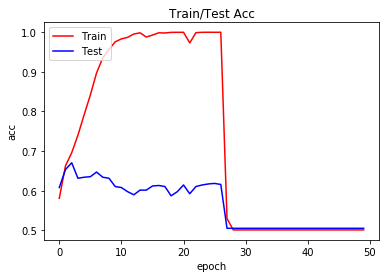

In [52]:
#plot train/val accuracies
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
line1 = plt.plot(train_acc_list, color='red')
line2 = plt.plot(val_acc_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpcpgrul1acc.png')   # save the figure to file
plt.show()
plt.close()

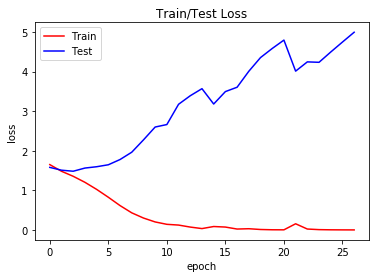

In [53]:
#plot train/val accuracies
plt.title("Train/Test Loss")
plt.xlabel("epoch")
plt.ylabel('loss')
line1 = plt.plot(train_loss_list, color='red')
line2 = plt.plot(val_loss_list, color='blue')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('nlpcpgrul1loss.png')   # save the figure to file
plt.show()
plt.close()

define model:
   
return $branch_1,branch_2...branch_n$

    
$pred_1, pred_2...pred_n = model(X)$


$loss_1 = lossfn_1(pred_1, y_1)$

$loss_2 = lossfn_2(pred_2, y_2)$

$loss_n = lossfn_n(pred_n, y_n)$

$\frac{1}{\alpha_1} = \frac{\frac{1}{loss_1}}{\frac{1}{loss_1} + \frac{1}{loss_2}+...\frac{1}{loss_n}}$

$\frac{1}{\alpha_2} = \frac{\frac{1}{loss_2}}{\frac{1}{loss_1} + \frac{1}{loss_2}+...\frac{1}{loss_n}}$

$\frac{1}{\alpha_n} = \frac{\frac{1}{loss_n}}{\frac{1}{loss_1} + \frac{1}{loss_2}+...\frac{1}{loss_n}}$

$optimizer_1.step(\alpha_1)$

$optimizer_2.step(\alpha_2)$

$optimizer_n.step(\alpha_n)$